In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    print("Please install the ucimlrepo with pip :)")

## Initial setup

First we fetch the data from ucirepo, and then do some basic analysis of the data.

In [3]:
# fetch dataset 
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878) 
  
# data (as pandas dataframes) 
X = cirrhosis_patient_survival_prediction.data.features 
  
# metadata 
print(cirrhosis_patient_survival_prediction.metadata) 
  
# variable information 
print(cirrhosis_patient_survival_prediction.variables)

data = pd.DataFrame(X)

{'uci_id': 878, 'name': 'Cirrhosis Patient Survival Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1', 'data_url': 'https://archive.ics.uci.edu/static/public/878/data.csv', 'abstract': 'Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 418, 'num_features': 17, 'feature_types': ['Real', 'Categorical'], 'demographics': ['Age', 'Sex'], 'target_col': ['Status'], 'index_col': ['ID'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5R02G', 'creators': ['E. Dickson', 'P. Grambsch', 'T. Fleming', 'L. Fisher', 'A. Langworthy'], 'intro_paper': {'ID': 296, 'type'

In [4]:
print(data.head())

              Drug    Age Sex Ascites Hepatomegaly Spiders Edema  Bilirubin  \
0  D-penicillamine  21464   F       Y            Y       Y     Y       14.5   
1  D-penicillamine  20617   F       N            Y       Y     N        1.1   
2  D-penicillamine  25594   M       N            N       N     S        1.4   
3  D-penicillamine  19994   F       N            Y       Y     S        1.8   
4          Placebo  13918   F       N            Y       Y     N        3.4   

  Cholesterol  Albumin Copper  Alk_Phos    SGOT Tryglicerides Platelets  \
0         261     2.60    156    1718.0  137.95           172       190   
1         302     4.14     54    7394.8  113.52            88       221   
2         176     3.48    210     516.0   96.10            55       151   
3         244     2.54     64    6121.8   60.63            92       183   
4         279     3.53    143     671.0  113.15            72       136   

   Prothrombin  Stage  
0         12.2    4.0  
1         10.6    3.0  
2 

In [5]:
#data preparation and cleaning

data = data.replace('NaNN', np.nan)

cols = data.columns

na_per_col = {}

for col in cols:
    na_per_col[col] = data[col].isna().sum()


for key, value in na_per_col.items():
    print(key, value)

Drug 106
Age 0
Sex 0
Ascites 106
Hepatomegaly 106
Spiders 106
Edema 0
Bilirubin 0
Cholesterol 134
Albumin 0
Copper 108
Alk_Phos 106
SGOT 106
Tryglicerides 136
Platelets 11
Prothrombin 2
Stage 6


In [6]:
data['Drug'].replace(['D-penicillamine', 'Placebo'], [1, 0], inplace=True)
data['Sex'].replace(['F', 'M'], [0, 1], inplace=True)
data['Ascites'].replace(['N', 'Y'], [0, 1], inplace=True)
data['Hepatomegaly'].replace(['N', 'Y'], [0, 1], inplace=True)
data['Spiders'].replace(['N', 'Y'], [0, 1], inplace=True)
data['Edema'].replace(['N', 'Y', 'S'], [0, 1, 2], inplace=True)

C:\Users\Leire\AppData\Local\Temp\ipykernel_4648\2112107566.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Drug'].replace(['D-penicillamine', 'Placebo'], [1, 0], inplace=True)
C:\Users\Leire\AppData\Local\Temp\ipykernel_4648\2112107566.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d

We realized there are some variables where the values are saved as strings and some of them had the value "NaNN", indicating a missing value, but not being detected as a nan. Here we count the number of missing values per variable.

In [7]:
print(data.describe())

             Drug           Age         Sex     Ascites  Hepatomegaly  \
count  312.000000    418.000000  418.000000  312.000000    312.000000   
mean     0.506410  18533.351675    0.105263    0.076923      0.512821   
std      0.500762   3815.845055    0.307260    0.266897      0.500639   
min      0.000000   9598.000000    0.000000    0.000000      0.000000   
25%      0.000000  15644.500000    0.000000    0.000000      0.000000   
50%      1.000000  18628.000000    0.000000    0.000000      1.000000   
75%      1.000000  21272.500000    0.000000    0.000000      1.000000   
max      1.000000  28650.000000    1.000000    1.000000      1.000000   

          Spiders       Edema   Bilirubin     Albumin      Alk_Phos  \
count  312.000000  418.000000  418.000000  418.000000    312.000000   
mean     0.288462    0.258373    3.220813    3.497440   1982.655769   
std      0.453775    0.634907    4.407506    0.424972   2140.388824   
min      0.000000    0.000000    0.300000    1.960000    2

# PCA

Now we'll analyze PCA and plot different things. First, we will drop the binary/text variables and drop all the touples containing missing values.

In [18]:
data.drop(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis=1, inplace=True)

data = data.dropna()

data.describe()

,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,18189.326087,3.333696,371.260870,3.516812,100.768116,1996.611594,124.119239,124.978261,261.771739,10.735507,3.039855
std,3843.555619,4.601074,234.788363,0.404789,88.268746,2115.477894,56.719952,65.280761,93.128857,1.008315,0.853999
min,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,28.380000,33.000000,62.000000,9.000000,1.000000
25%,15162.500000,0.800000,249.500000,3.310000,42.750000,922.500000,82.457500,85.000000,200.000000,10.000000,2.000000
50%,18156.500000,1.400000,310.000000,3.545000,74.000000,1277.500000,116.625000,108.000000,257.000000,10.600000,3.000000
75%,20667.500000,3.525000,401.000000,3.772500,129.250000,2068.250000,153.450000,151.250000,318.250000,11.200000,4.000000
max,28650.000000,28.000000,1775.000000,4.400000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000


Now, converting all strings to int

In [9]:
#convert all data to integers

ints = ['Age', 'Copper', 'Platelets', 'Cholesterol', 'Tryglicerides']

for i in ints:
    print(i)
    data[i] = list(map(int, data[i]))

Age
Copper
Platelets
Cholesterol
Tryglicerides


No we will fill a matrix with the values for easo of use for the PCA, plotting and transformations.

In [10]:
print(len(data))

276


In [24]:
# Extract attribute names (1st row, column 4 to 12)
attributeNames = list(data.columns)

# Extract class names to python list
classLabels = sorted(set(data.Age))
y = data.Age

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), 10))
for i, col_id in enumerate(range(1,11)):
    X[:, i] = np.asarray(data.iloc[:, col_id])

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classLabels)

print(N, M, C)

276 11 275


In [25]:
convert = ['Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Prothrombin', 'Cholesterol', 'Bilirubin']

# Convert the columns to log scale
# for col in convert:
#     data[col] = np.log(data[col])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), 10))
for i, col_id in enumerate(range(0,10)):
    X[:, i] = np.asarray(data.iloc[:, col_id])

scaler = StandardScaler()
Y_scaled = scaler.fit_transform(X)

# Subtract mean value from data
Y_scaled = Y_scaled - np.ones((N, 1)) * Y_scaled.mean(0)

In [ ]:
alk_phos_2 = Y_scaled[:, 1]**2
alk_phos_3 = Y_scaled[:, 1]**3


In [13]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
from sklearn import model_selection
import numpy as np
import sklearn.linear_model
import sklearn.neural_network

K1 = 3
K2 = 3

X = Y_scaled[:,1:]
y = Y_scaled[:,0]

k1 = 0
k2 = 0

lambda_range = list(np.arange(0.1, 100, 0.1))
hidden_range = list(range(1, 50))

test_lens = []

for par_index, test_index in model_selection.KFold(K1).split(X):
    print("Outter fold: {0}/{1}".format(k1 + 1, K1))

    X_par, X_test = X[par_index,:], X[test_index,:]
    y_par, y_test = y[par_index], y[test_index]


    lr_generr = []
    ann_generr = []

    train_val_fracs = []

    k2 = 0

    for train_index, val_index in model_selection.KFold(K2).split(X_par):
        print("Cross-validation fold: {0}/{1}".format(k2 + 1, K2))

        X_train, X_val = X_par[train_index,:], X_par[val_index,:]
        y_train, y_val = y_par[train_index], y_par[val_index]

        train_val_fracs.append(len(X_train)/len(X_val))

        # Train linnear regression model (ranging lambda regularization parameter)
        lr_valerr = []
        for l in lambda_range:
            mA = sklearn.linear_model.Ridge(alpha=l).fit(X_train, y_train)
            lr_preds = mA.predict(X_val)
            lr_valerr.append(np.mean((lr_preds - y_val) ** 2))
        lr_generr.append(lr_valerr)
        
        # Train ANN model
        ann_valerr = []
        for h in hidden_range:
            mB = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(h,), activation='relu', solver='adam').fit(X_train, y_train)
            ann_preds = mB.predict(X_val)
            ann_valerr.append(np.mean((ann_preds - y_val) ** 2))
        ann_generr.append(ann_valerr)

        k2 += 1

    # Compute generalization errors

    # LINNEAR REGRESSION
    lr_generr = np.dot(np.array(train_val_fracs), np.array(lr_generr))
    # Choose best model
    best_lambda = lambda_range[np.argmin(lr_generr)]
    mA = sklearn.linear_model.Ridge(alpha=best_lambda).fit(X_par, y_par)
    lr_testerr = np.mean((mA.predict(X_test) - y_test) ** 2)

    print("Best lambda: {0}".format(best_lambda))
    print("Linneal regression test error: {0}".format(lr_testerr))

    # ANN REGRESSION
    ann_generr = np.dot(np.array(train_val_fracs), np.array(ann_generr))
    # Choose best model
    best_hidden = hidden_range[np.argmin(ann_generr)]
    mB = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(best_hidden,)).fit(X_par, y_par)
    ann_testerr = np.mean((mB.predict(X_test) - y_test) ** 2)

    print("Best hidden layer size: {0}".format(best_hidden))
    print("ANN test error: {0}".format(ann_testerr))

    # BASELINE
    y_baseline = np.mean(y_par) * np.ones(len(y_test))
    baseline_testerr = np.mean((y_baseline - y_test) ** 2)

    print(baseline_testerr)

    k1 += 1

# Estimate of generalization error (not shown on the table)

# LINNEAR REGRESSION
# lr_gen = np.dot(np.array(test_lens), np.array(lr_generr))

# ANN REGRESSION
#ann_gen = np.dot(np.array(test_lens), np.array(ann_generr))

# BASELINE, not sure what goes here


Outter fold: 1/3
Cross-validation fold: 1/3
Cross-validation fold: 2/3
Cross-validation fold: 3/3
Best lambda: 46.6
Linneal regression test error: 0.7739214489940349
Best hidden layer size: 20
ANN test error: 0.8930003982899363
0.847471601270361
Outter fold: 2/3
Cross-validation fold: 1/3
Cross-validation fold: 2/3
Cross-validation fold: 3/3
Best lambda: 59.6
Linneal regression test error: 0.8006643899102627
Best hidden layer size: 41
ANN test error: 0.8142848872718101
0.9078560322422464
Outter fold: 3/3
Cross-validation fold: 1/3
Cross-validation fold: 2/3
Cross-validation fold: 3/3
Best lambda: 33.400000000000006
Linneal regression test error: 1.1618465377681304
Best hidden layer size: 19
ANN test error: 1.2518793174240193
1.2710880113417702


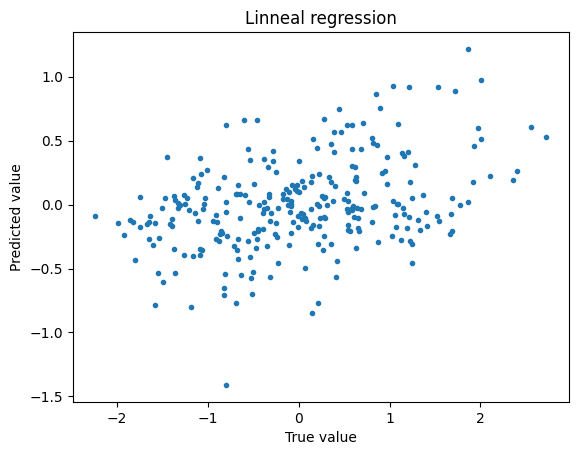

In [27]:
mA = sklearn.linear_model.Ridge(alpha=best_lambda).fit(X, y)
pred_y = mA.predict(X)

plt.figure()
plt.plot(y, pred_y, '.')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('Linneal regression')
plt.show()